In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
import numpy as np
from pathlib import Path
import modules.guided_diffusion as gd
from modules.dataset import CustomDataset

def create_gaussian_diffusion(
        *,
        steps=1000,
        learn_sigma=False,
        sigma_small=False,
        noise_schedule="linear",
        use_kl=False,
        predict_xstart=False,
        rescale_timesteps=False,
        rescale_learned_sigmas=False,
        timestep_respacing="",
):
    betas = gd.get_named_beta_schedule(noise_schedule, steps)
    if use_kl:
        loss_type = gd.LossType.RESCALED_KL
    elif rescale_learned_sigmas:
        loss_type = gd.LossType.RESCALED_MSE
    else:
        loss_type = gd.LossType.MSE
    if not timestep_respacing:
        timestep_respacing = [steps]
    return gd.SpacedDiffusion(
        use_timesteps=gd.space_timesteps(steps, timestep_respacing),
        betas=betas,
        model_mean_type=(
            gd.ModelMeanType.EPSILON if not predict_xstart else gd.ModelMeanType.START_X
        ),
        model_var_type=(
            (
                gd.ModelVarType.FIXED_LARGE
                if not sigma_small
                else gd.ModelVarType.FIXED_SMALL
            )
            if not learn_sigma
            else gd.ModelVarType.LEARNED_RANGE
        ),
        loss_type=loss_type,
        rescale_timesteps=rescale_timesteps,
    )

 # Overfitting

Num params:  55719105


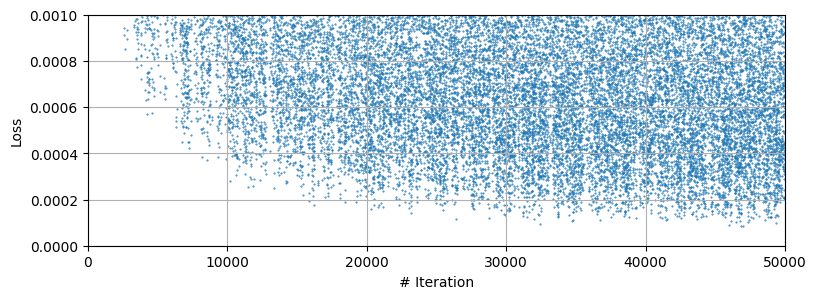

In [106]:
diffusion2 = create_gaussian_diffusion(noise_schedule='cosine')

from modules.model import UNETv2
from modules.plotting_utils import *

device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
save_dir = Path(r'.\weights_overfit')
training_epochs = 50000
model2 = UNETv2(in_channels=80, residual=False, attention_res=[]).to(device)
model2.load_state_dict(torch.load(save_dir / f"model_{training_epochs}.pth", map_location=device))
print("Num params: ", sum(p.numel() for p in model2.parameters()))

plt.figure(figsize=(9, 3))
loss_npy = np.load(save_dir / f"loss_{training_epochs}.npy")
plt.scatter([x for x in range(len(loss_npy))], loss_npy, s=0.2)
plt.xlabel('# Iteration')
plt.ylabel('Loss')
plt.xlim(0,50000)
plt.ylim(0, 0.001)
plt.grid()
plt.show()


In [14]:
data_folder = Path(r'C:\Users\smerino.C084288\Documents\Datasets\ACS')
data2 = CustomDataset(data_folder / 'train_overfit')
from scipy.signal import hilbert
from scipy.io import loadmat
import os

mat_folder = data_folder / 'raw'
mat_file_list = sorted(os.listdir(mat_folder))
extentBm = (-1.905, 1.905, 3.9, 0.0)
extent_ACS = (-1.845, 1.845, 3.751, 0.128)

In [107]:

sample_id = 0
x_sample, y_sample = data2.__getitem__(sample_id)
x_sample = x_sample.unsqueeze(0)
y_sample = y_sample.unsqueeze(0)

data_dict = loadmat(str(mat_folder / data2.data_file_list[sample_id]))
rf = data_dict['rf']
Bmode = 20 * np.log10(np.abs(hilbert(rf, axis=0)))
Bmode = Bmode - np.max(Bmode)

# Sampling
(b, c, m, n) = x_sample.shape
pad_m = (m // 16 + 1) * 16 - m
pad_n = (n // 16 + 1) * 16 - n
x_pad = torch.cat((x_sample, torch.zeros((b, c, pad_m, n), device=device)), dim=2)
x_pad = torch.cat((x_pad, torch.zeros((b, c, m + pad_m, pad_n),device=device)), dim=3)
y_pad = torch.cat((y_sample, torch.zeros((b, 1, pad_m, n), device=device)), dim=2)
y_pad = torch.cat((y_pad, torch.zeros((b, 1, m + pad_m, pad_n),device=device)), dim=3)

intermediate_sample = []
intermediate_x0 = []
for step in diffusion2.p_sample_loop_progressive(model2, y_pad.shape, x_pad, progress=True, clip_denoised=False):
    intermediate_sample.append(step['sample'].cpu().detach()[:, :, :m, :n])
    intermediate_x0.append(step['pred_xstart'].cpu().detach()[:, :, :m, :n])
    

  0%|          | 0/1000 [00:00<?, ?it/s]

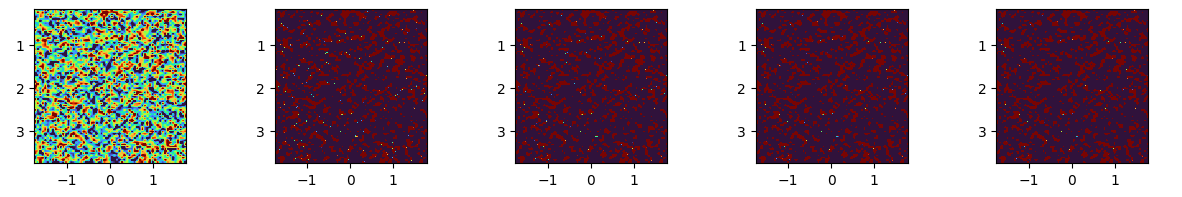

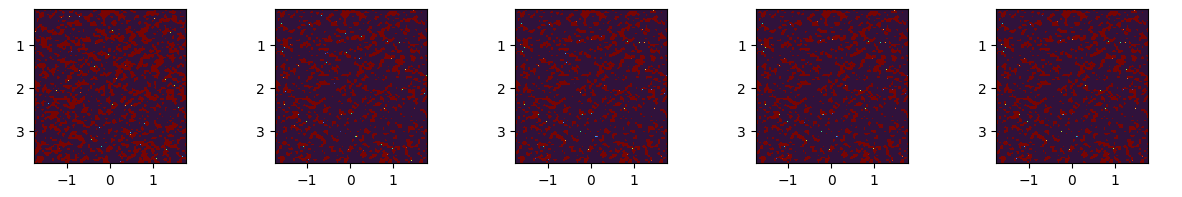

In [109]:
show_reverse_process(intermediate_sample[::200])
show_reverse_process(intermediate_x0[::200])

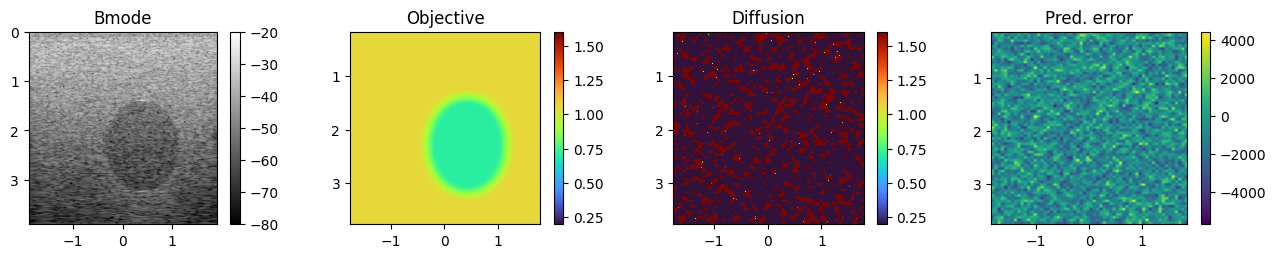

In [110]:
plt.figure(figsize=(16, 2.5))
plt.subplot(1, 4, 1)
plt.imshow(Bmode, cmap='gray', extent=extentBm)
plt.clim([-80, -20])
plt.colorbar()
plt.title('Bmode') 

plt.subplot(1, 4, 2)
show_tensor_image(y_sample.cpu())
plt.colorbar()
plt.set_cmap('turbo')
plt.title('Objective')

plt.subplot(1, 4, 3)
show_tensor_image(intermediate_sample[-1])
plt.colorbar()
plt.set_cmap('turbo')
plt.title('Diffusion')

acs_error = (intermediate_sample[-1] - y_sample).detach().cpu().numpy().squeeze()
plt.subplot(1, 4, 4)
plt.imshow(acs_error, extent=extent_ACS, cmap='viridis')
plt.colorbar()
plt.title('Pred. error')
plt.show()


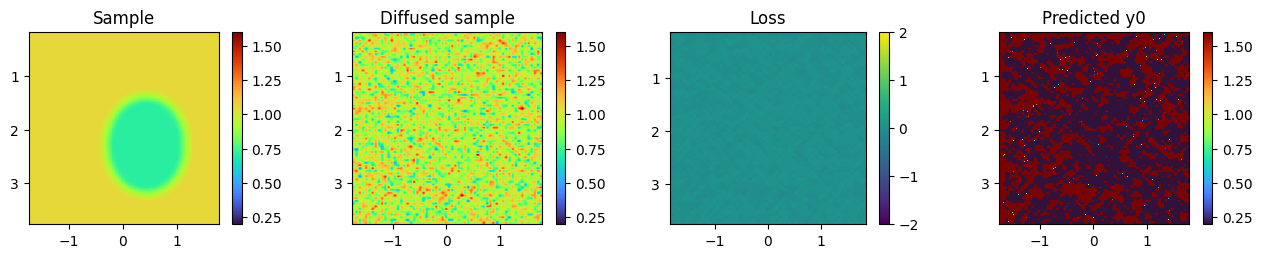

In [116]:
timestep = 999
noise = torch.randn_like(y_sample)
t = torch.reshape(torch.Tensor([timestep]).int(), (x_sample.shape[0],)).to(device)
y_pert = diffusion2.q_sample(y_sample, t, noise)

# use network to recover noise
(b, c, m, n) = x_sample.shape
pad_m = (m // 16 + 1) * 16 - m
pad_n = (n // 16 + 1) * 16 - n
x_pad = torch.cat((x_sample, torch.zeros((b, c, pad_m, n), device=device)), dim=2)
x_pad = torch.cat((x_pad, torch.zeros((b, c, m + pad_m, pad_n),device=device)), dim=3)
y_pad = torch.cat((y_pert, torch.zeros((b, 1, pad_m, n), device=device)), dim=2)
y_pad = torch.cat((y_pad, torch.zeros((b, 1, m + pad_m, pad_n),device=device)), dim=3)
with torch.inference_mode():
    pred = diffusion2.p_mean_variance(model2, x_pad, y_pad, t,clip_denoised=False)
    y_0 = pred['pred_xstart'][:,:,:m,:n]
    predicted_noise = model2(x_pad, y_pad, t)
    predicted_noise = predicted_noise[0,0,:m,:n]


plt.figure(figsize=(16, 2.5))
plt.subplot(1, 4, 1)
show_tensor_image(y_sample.cpu().detach())
plt.set_cmap('turbo')
plt.colorbar()
plt.title('Sample')

plt.subplot(1, 4, 2)
show_tensor_image(y_pert.cpu().detach())
plt.colorbar()
plt.set_cmap('turbo')
plt.title('Diffused sample')

pred_error = (predicted_noise-noise).cpu().detach().squeeze()
plt.subplot(1, 4, 3)
plt.imshow(pred_error, extent=extent_ACS)
plt.colorbar()
plt.clim(-2, 2)
plt.set_cmap('viridis')
plt.title('Loss')

plt.subplot(1, 4, 4)
show_tensor_image(y_0.cpu().detach())
plt.colorbar()
plt.set_cmap('turbo')
plt.title('Predicted y0')
plt.show()
